In [1]:
import SiemensQuadraProperties as sqp
import CoincidenceGeneration as cg
import SimulationDataset as sd
import PhysicsConstants as pc
import GATEfileWriter as gf
import time

import matplotlib.pyplot as plt
params = {'legend.fontsize': 15,
          'legend.title_fontsize': 15,
          'legend.loc': "upper left",
          'axes.labelsize': 15,
          'xtick.labelsize': 15,
          'ytick.labelsize': 15}
plt.rcParams.update(params)

# Fix random seed for reproducibility, or leave blank to allow the results to vary
import numpy as np
RNG = np.random.default_rng(1234)

# Set batch size for coincidence generation
# Larger batches will use more RAM, and will eventually become inefficient due to wasted events
# Smaller batches are inefficient due to overheads
# 256-1024 seems to be about right
BATCH_SIZE=1024

Using an analogous structure to the NECR notebook, but this just creates a single data sample, and then saves it in a GATE-compatible ROOT file

In [2]:
def FileAtTimeF18( tracerData, crystalData, crystalActivity, detectorRadius, phantomLength, \
                   simulationWindow=1E7, coincidenceWindow=4.7, zWindow=325.0, EnergyMin=0.0, EnergyMax=0.0 ):

    # Create a moduleID lookup table
    moduleIDs = tracerData.GetModuleIDs()
    if crystalData is not None:
        moduleIDs.update( crystalData.GetModuleIDs() )

    start = time.time_ns()

    # Perform the NECR calculation at 20 minute intervals, following NEMA standard
    #for experimentTime in range( 0, 700, 20 ):

    experimentTime = 0
    timeSec = float(experimentTime) * 60.0

    # Assemble data sources, including crystal intrinsic background if necessary
    activityList = []
    dataList = []
    tracerActivity = pc.TracerActivityAtTime( 1100E6, timeSec, "F18" )
    if crystalData is not None:
        activityList = [tracerActivity, crystalActivity]
        dataList = [tracerData, crystalData]
    else :
        activityList = [tracerActivity]
        dataList = [tracerData]

    # Create a generator object that will simulate radioactive decays and load Geant4 events
    generator = cg.GenerateCoincidences( BATCH_SIZE, activityList, dataList, RNG, coincidenceWindow, simulationWindow, \
                                         MultiWindow=False, EnergyResolution=0.0, EnergyMin=EnergyMin, EnergyMax=EnergyMax, TimeResolution=0.0 )

    # Save photons to a GATE format file
    fileName = "testGATEoutput.root"
    gf.GATEfromGenerator( BATCH_SIZE, generator, fileName, moduleIDs, detectorRadius, PairMode="Exclusive", ZMin=-zWindow, ZMax=zWindow )

    end = time.time_ns()
    print( "Photon generation and writing: " + str( (end-start)/1e9 ) + "s" )


# Simulation parameters
detectorLength = 100 #1024 for standard quadra
phantomLength = 700
datasetSize = 1000000
siemensEmin = 435.0
siemensEmax = 585.0

# Have to use the full-detail (Crystal) version of the geometry to get the GATE module IDs
detectorMaterial = "LSO"
tracerData = sd.CreateDataset( detectorLength, "SiemensCrystal", phantomLength, "LinearF18", datasetSize, siemensEmin, siemensEmax, detectorMaterial, UseNumpy=True )
crystalData = None
crystalActivity = 0.0
if detectorMaterial == "LSO" or detectorMaterial == "LYSO":
    crystalData = sd.CreateDataset( detectorLength, "SiemensCrystal", phantomLength, "Siemens", datasetSize, siemensEmin, siemensEmax, detectorMaterial, UseNumpy=True )
    crystalActivity = sqp.Lu176decaysInMass( sqp.DetectorMass(detectorMaterial) )

# Write out a file for a single NECR sample
FileAtTimeF18( tracerData, crystalData, crystalActivity, sqp.DetectorRadius(), phantomLength, EnergyMin=siemensEmin, EnergyMax=siemensEmax )

Re-using previous simulation
Using a high-granularity "Crystal" detector geometry with no clusterisation
Setting to recommended value (20mm), specify 0 to override
222911 events loaded (1000000 simulated) with average 0.242133 hits/event
Re-using previous simulation
Using a high-granularity "Crystal" detector geometry with no clusterisation
Setting to recommended value (20mm), specify 0 to override
994895 events loaded (1000000 simulated) with average 1.196597 hits/event
Photon generation and writing: 1.848039206s


Now let's take the file that was created, open it with upROOT, and make simple debug plots

In [3]:
import uproot

# Helper function to fill arrays
def initOrAppend( target, events, branch ):
  if target is None:
    target = events[ branch + "1" ]
  else:
    target = np.append( target, events[ branch + "1" ] )
  target = np.append( target, events[ branch + "2" ] )
  return target


# Get position arrays and a value to use for colours
xVals = None
yVals = None
zVals = None
cVals = None
rsVals = None
smVals = None
for events in uproot.iterate( "testGATEoutput.root:Coincidences" ):

  xVals = initOrAppend( xVals, events, "globalPosX" )
  yVals = initOrAppend( yVals, events, "globalPosY" )
  zVals = initOrAppend( zVals, events, "globalPosZ" )
  cVals = initOrAppend( cVals, events, "crystalID" )
  rsVals = initOrAppend( rsVals, events, "rsectorID" )
  smVals = initOrAppend( smVals, events, "submoduleID" )

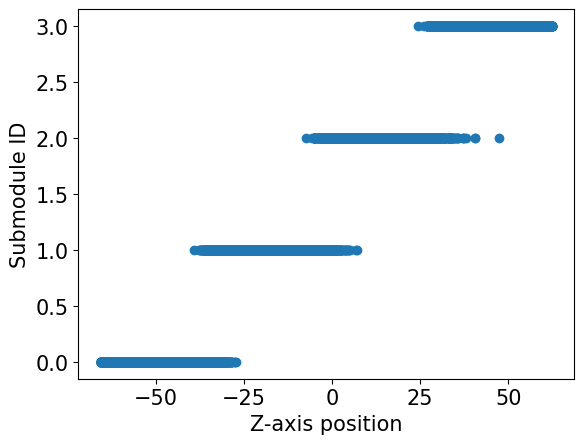

In [4]:
# Submodule ID basically behaves like rings in Z-axis, so should see linear increase

plt.scatter( zVals, smVals )
plt.xlabel( "Z-axis position" )
plt.ylabel( "Submodule ID" )
plt.show()

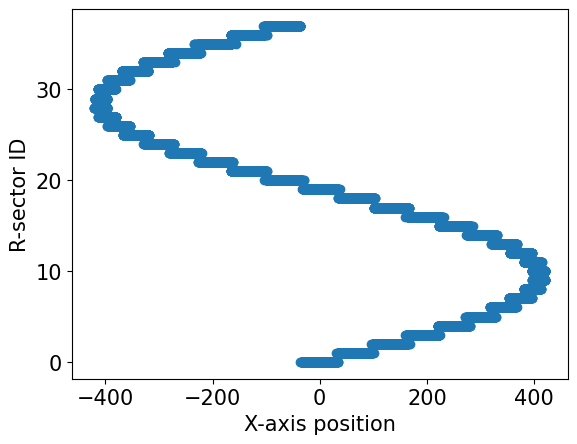

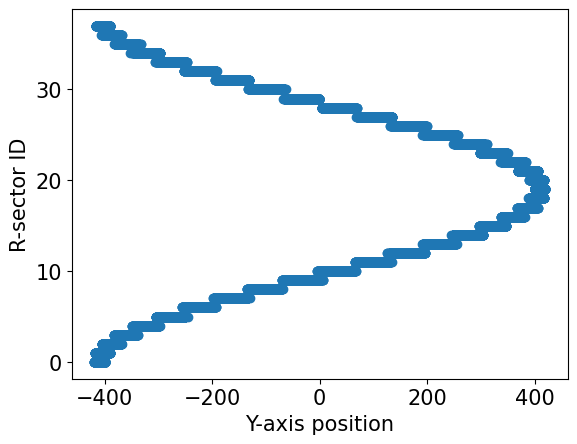

In [5]:
# R-sector ID increases around the ring, so we should see sin/cos functions vs x/y

plt.scatter( xVals, rsVals )
plt.xlabel( "X-axis position" )
plt.ylabel( "R-sector ID" )
plt.show()
plt.scatter( yVals, rsVals )
plt.xlabel( "Y-axis position" )
plt.ylabel( "R-sector ID" )
plt.show()

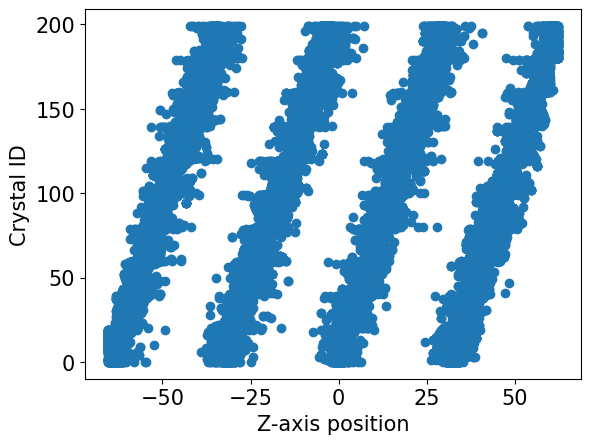

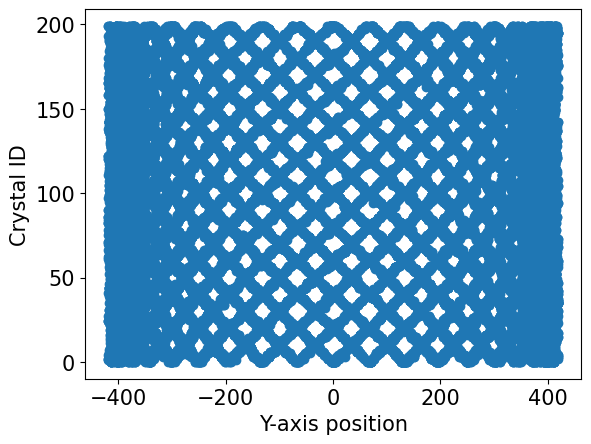

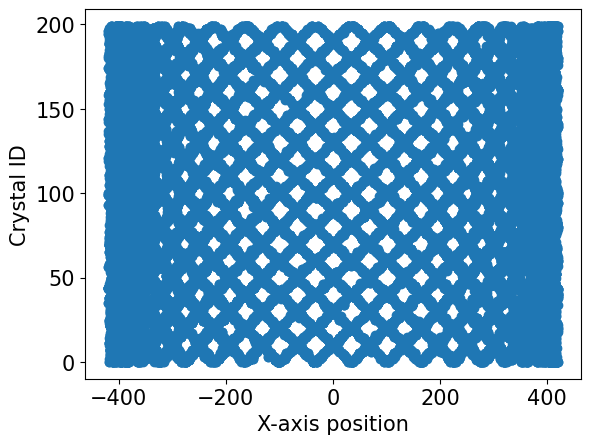

In [6]:
# Crystal ID will be scattered across each module

plt.scatter( zVals, cVals )
plt.xlabel( "Z-axis position" )
plt.ylabel( "Crystal ID" )
plt.show()
plt.scatter( yVals, cVals )
plt.xlabel( "Y-axis position" )
plt.ylabel( "Crystal ID" )
plt.show()
plt.scatter( xVals, cVals )
plt.xlabel( "X-axis position" )
plt.ylabel( "Crystal ID" )
plt.show()

Of course this would all be much nicer in Open3D, but I don't want to try embedding that or adding the dependency